In [508]:
# Initialize Otter
import otter
grader = otter.Notebook("hw03_completed.ipynb")

# Homework 8: Understanding Cook County Home Value Appraisals

## Due Date: Thursday, June 30th, 11:59 PM CET

**Group members:** *list names here*

## Introduction

In Homework 3, we will go through the iterative process of specifying, fitting, and analyzing the performance of a  model.  

In the first portion of the assignment, we will guide you through some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Next, you will be adding a few new features to the dataset, cleaning the data as well in the process.

Later in this Homework, you will specify and fit a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this assignment - and think about what fairness might mean to property owners in Cook County.

After this homework, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`
- Using `scikit-learn` to build and fit linear models



## Score Breakdown

Question | Part | Points
----|----|----
2 | 2 | 1
3 | 1 | 3
3 | 2 | 1
3 | 3 | 1
4 | - | 2
5 | 1 | 1
5 | 2 | 2
5 | 3 | 1
6 | 1 | 1
6 | 2 | 2
6 | 3 | 2
6 | 4 | 1
7 | 1 | 1
7 | 2 | 2
8 | - | 2
9a | - | 1
9b | - | 4
10 | - | 2
11 | - | 2
12 | - | 2
Total | - | 34

In [509]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Cook County Assessor's Office

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing [“racially discriminatory assessments and taxes."](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html) The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, ["The Tax Divide"](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html), delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments [had] been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

Additionally, the discrimination described in the lawsuit is built on a much deeper history - including the practice of redlining in Chicago. Though this is by no means a comprehensive history, Merriam-Webster defines redlining as the "withholdding of home-loan funds or insurance from neighborhoods considered poor economic risks." The neighborhoods in this category, however, were typically comprised of Black communities; redlining, then, systemically prevented Black residents from moving into other neighborhoods and improving their current homes by denying them the financial assistance that white residents were afforded. Though the Fair Housing Act of 1968 outlawed redlining, its [impacts](https://www.washingtonpost.com/news/wonk/wp/2018/03/28/redlining-was-banned-50-years-ago-its-still-hurting-minorities-today/) and [practices](https://www.chicagotribune.com/business/ct-biz-modern-day-redlining-20180215-story.html) are still present today.

This context is vital to understanding how the Cook County Residential Sales Data - the dataset you'll be working with - was procured. This introduction aims to address how legacies of racial discrimination practices can be encoded within data, as well as consider how they might influence modeling choices.

<!-- END QUESTION -->



# The Data

The [CCAO dataset](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) consists of over 500 thousand records describing houses sold in Cook County in recent years (new records are still coming in every week!). The data set we will be working with has 61 features in total. An explanation of each variable can be found in the included `codebook.txt` file. Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting. For more context about this dataset please see [Lecture 15](https://ds100.org/su21/lecture/lec15/).

The data are split into training and test sets with 204792 and 68264 observations, respectively.

Let's first extract the data from the `cook_county_data.zip`. Notice we didn't leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [510]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

Let's load the training and test data.

In [511]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [512]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# 68264 observations and 61 features in test data
assert test_data.shape == (68264, 61)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

The next order of business is getting a feel for the variables in our data.  The Cook County data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt` (in the same directory as this notebook).  **You should take some time to familiarize yourself with the codebook before moving forward.**

Let's take a quick look at all the current columns in our training data.

In [513]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

In [514]:
training_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [515]:
regex = r'(\d+) of which are bedrooms'


<!-- BEGIN QUESTION -->

# Part 1: Contextualizing the Data

Let's try to understand the background of our dataset before diving into a full-scale analysis. 

Prior to the open data initiative and even prior to the assessment modeling initiative, Cook County’s assessor office received much of their data for assessments from their relationships with [“local elected officials, community leaders, real estate professionals and other citizens knowledgeable about real estate in the area.”](https://www.cookcountyassessor.com/about-cook-county-assessors-office) Because CCAO field inspectors cannot enter homes to gather data, this information must be gathered through either curbside observations or real estate records.

You can read more about data collection in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf).


1- Take a moment to assess the granularity of this dataset. What does each row represent?


2- Think about a feature that isn't listed in this dataset but may be useful for predicting sales values. What insights could this feature provide? How might it increase or decrease a home’s sales value?

3- Let’s take a look at the `Site Desirability` column. What do the column’s values represent? Does the codebook provide sufficient guidelines as to how a property's `Site Desirability` is determined? Why or why not?

Just by looking at the feature and its description, we can tell that `Site Desirability` is highly discretionary - that is, it relies on an individual's interpretation, which is informed by historically and socially-determined practices. And in this context, the individual in question would be a real estate agent or assessor.

4- Beyond a home’s internal characteristics (such as number of rooms, bathrooms, etc.), think about a factor that might influence whether a home is desirable, and elaborate why. Think from the perspective of a real estate agent - i.e. what would an agent market to potential buyers and why?
One might consider characteristics related to a home’s location and its proximity to other places.

<!-- END QUESTION -->



When examining your data, it’s important to consider who collects the data in order to understand the assumptions and perspectives built into it. Here, the idea of desirable properties is influenced by what the real estate industry - a source of expertise in home valuations - deems popular with its market. These human choices about value are shaped by the real estate agents' expertise acquired through their professional training and experience. From a seller's perspective, this expertise also makes the agent's valuations legitimate and authoritative in a way that's difficult to contest. As a result, a form of professional bias enters into the valuation process, and though this bias isn’t inherently bad, we’ll delve deeper into how it interacts with, and often reinforces, structural inequity.

To continue using `Site Desirability` as an example, let’s say that proximity to high-ranking schools adds to a home’s desirability. Because schools are largely funded by property taxes, high-ranking schools are typically located near homes in higher-income neighborhoods. Comparatively, homes in lower-income neighborhoods - with families predominantly from Hispanic and Black communities - would be deemed “less desirable” because they would not feed into high-ranking schools, further devaluing homes in lower-income neighborhoods.

In this way, `Site Desirability` acts as a proxy for sensitive attributes, such as the racial distribution of a neighborhood. Although it does not explicitly name these attributes, `Site Desirability` ultimately encodes the broader socioeconomic and racial context of a home’s surrounding community. And because real estate agents affirm their classifications of `Site Desirability` based on their expertise, structural inequity is further perpetuated as this bias is embedded in the data used to generate housing valuation models.

Understanding your dataset provides a lot of insight into how models might incorporate bias from the very beginning. A data scientist with this awareness would not only identify sources of bias, but also aim to intentionally address these biases in their data analyses, as well as the outputs and recommendations based on these analyses. As we progress through this homework, keep these perspectives on bias and expertise in mind.

# Part 2: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining the distribution of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable. We have provided the following helper method `plot_distribution` that you can use to visualize the distribution of the `SalePrice` using both the histogram and the box plot at the same time. Run the following 2 cells and describe what you think is wrong with the visualization.

In [516]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

    # Adjust boxplot fill to be white
    axs[1].set_facecolor('white')

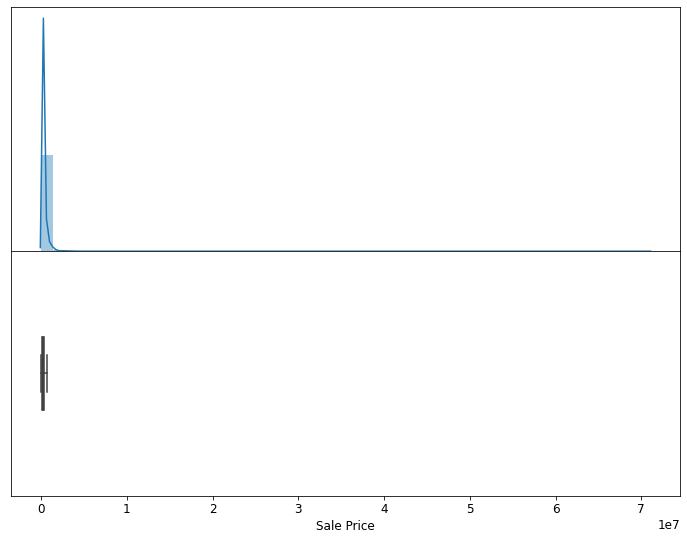

In [517]:
plot_distribution(training_data, label='Sale Price')

<!-- BEGIN QUESTION -->

## Question 2

### Part 1

Identify one issue with the visualization above and think about one way to overcome it. You may also want to try running `training_data['Sale Price'].describe()` in a different cell to see some specific summary statistics on the distribution of the target variable. Make sure to delete the cell afterwards as the autograder may not work otherwise.

<!--
BEGIN QUESTION
name: q2a
points: 1
manual: True
-->

<!-- END QUESTION -->

### Part 2

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price` for this assignment. In addition, it may be a good idea to apply log transformation to `Sale Price`. In the cell below, reassign `training_data` to a new dataframe that is the same as the original one **except with the following changes**:

- `training_data` should contain only households whose price is at least $500.
- `training_data` should contain a new `Log Sale Price` column that contains the log-transformed sale prices.

**Note**: This also implies from now on, our target variable in the model will be the log transformed sale prices from the column `Log Sale Price`. 

**Note**: You should **NOT** remove the original column `Sale Price` as it will be helpful for later questions.

*To ensure that any error from this part does not propagate to later questions, there will be no hidden test here.*


<!--
BEGIN QUESTION
name: q2b
points: 1
-->

In [518]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data['Log Sale Price'] = np.log(training_data['Sale Price'])

In [519]:
grader.check("q2b")

q2b results: All test cases passed!

Let's create a new distribution plot on the log-transformed sale price.

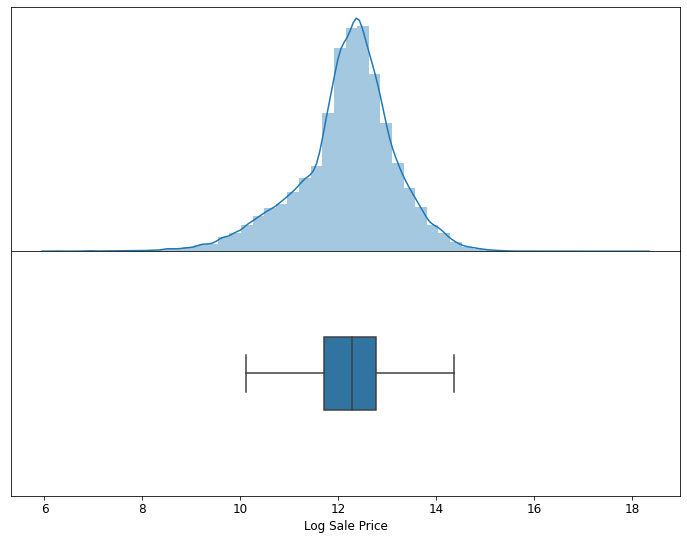

In [520]:
plot_distribution(training_data, label='Log Sale Price');

## Question 3

### Part 1
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `Log Sale Price` in the training set is left-skewed.
1. The mean of `Log Sale Price` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to `True` or `False`.*

<!--
BEGIN QUESTION
name: q3a
points:
- 0
- 1
- 1
- 1
-->

In [521]:
# These should be True or False
q3statement1 = True
q3statement2 = False
q3statement3 = True

In [522]:
grader.check("q3a")

q3a results: All test cases passed!

### Part 2

Next, we want to explore if any there is any correlation between `Log Sale Price` and the total area occupied by the household. The `codebook.txt` file tells us the column `Building Square Feet` should do the trick -- it measures "(from the exterior) the total area, in square feet, occupied by the building".

Before creating this jointplot however, let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, create a new column `Log Building Square Feet` in our training data that contains the log transformed area occupied by each household. 

**You should NOT remove the original `Building Square Feet` column this time as it will be used for later questions**. 

*To ensure that any errors from this part do not propagate to later questions, there will be no hidden tests here.*

<!--
BEGIN QUESTION
name: q3b
points: 1
-->

In [523]:
training_data['Log Building Square Feet'] = np.log(training_data['Building Square Feet'])

In [524]:
grader.check("q3b")

q3b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Part 3

As shown below, we created a joint plot with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, we fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, does there exist a correlation between `Log Sale Price` and `Log Building Square Feet`? Would `Log Building Square Feet` make a good candidate as one of the features for our model? Answer with True or False.

![Joint Plot](images/q2p3_jointplot.png)

<!--
BEGIN QUESTION
name: q3c
points: 1
-->

In [525]:
q3statement4 = True

In [526]:
grader.check('q3c')

q3b results: All test cases passed!

<!-- END QUESTION -->

## Question 4

Continuing from the previous part, as you explore the data set, you might still run into more outliers that prevent you from creating a clear visualization or capturing the trend of the majority of the houses. 

For this assignment, we will work to remove these outliers from the data as we run into them. Write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Building Square Feet', upper=8000)` should return a data frame with only observations that satisfy `Building Square Feet` less than or equal to 8000.

*The provided tests check that training_data was updated correctly, so that future analyses are not corrupted by a mistake. However, the provided tests do not check that you have implemented remove_outliers correctly so that it works with any data, variable, lower, and upper bound.*

<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [527]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] <= upper) & (data[variable] >= lower)]

In [528]:
grader.check("q4")

q4 results: All test cases passed!

# Part 3: Feature Engineering

In this section we will walk you through a few feature engineering techniques. 

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. You may notice that the `Bedrooms` column doesn't actually exist in the original dataframe! Instead, it is part of the `Description` column.

## Question 5

### Part 1

Let's take a closer look at the `Description` column first. Compare the description across a few rows together at the same time. For the following list of variables, how many of them can be extracted from the `Description` column? Assign your answer as an integer to the variable `q5a`.
- The date the property was sold on
- The number of stories the property contains
- The previous owner of the property
- The address of the property
- The number of garages the property has
- The total number of rooms inside the property
- The total number of bedrooms inside the property
- The total number of bathrooms inside the property


<!--
BEGIN QUESTION
name: q5a
points:
- 0
- 1
-->

In [529]:
q5a = 6

In [530]:
grader.check("q5a")

q5a results: All test cases passed!

### Part 2

Write a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bedrooms (as integers) for each house. **Treat missing values as zeros if necessary**. Remember that you can make use of vectorized code here; you shouldn't need any `for` statements. 

**Hint**: You should consider inspecting the `Description` column to figure out if there is any general structure within the text. Once you have noticed a certain pattern, you are set with the power of Regex!

<!--
BEGIN QUESTION
name: q5b
points: 2
-->

In [531]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms['Bedrooms'] = with_rooms['Description'].str.extract(regex).astype(int)
    return with_rooms

training_data = add_total_bedrooms(training_data)

In [532]:
grader.check("q5b")

q5b results: All test cases passed!

### Part 3

Assign `correlation_value` to the correlation between column `Bedrooms` and `Log Sale Price` to see if there exists an association between  `Bedrooms` and `Log Sale Price`.
Note that `correlation_value` should contain a single integer value.

<!--
BEGIN QUESTION
name: q5c
points: 1
-->

In [533]:
correlation_value = np.corrcoef(training_data['Bedrooms'], training_data['Log Sale Price'])[0][1]
correlation_value

0.4279429510512979

In [534]:
grader.check('q5c')

q5b results: All test cases passed!

<!-- END QUESTION -->



## Question 6

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

### Part 1

Before creating any visualization, let's quickly inspect how many different neighborhoods we are dealing with.

Assign the variable `num_neighborhoods` with the total number of neighborhoods in `training_data`. 

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [535]:
num_neighborhoods = len(training_data['Neighborhood Code'].unique())
num_neighborhoods

193

In [536]:
grader.check("q6a")

q6a results: All test cases passed!

### Part  2

If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we would get the following visualization.
![overplot](images/q5p2_catplot.png)

In [537]:
def plot_categorical(neighborhoods, data, with_filter=True):
    if not with_filter:
        neighborhoods = data
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods.sort_values('Neighborhood Code'),
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

Oh no, looks like we have run into the problem of overplotting! 

You might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

Assign the variable `in_top_20_neighborhoods` to a copy of `training_data` that contains only neighborhoods with the top 20 number of buildings. 

<!--
BEGIN QUESTION
name: q6b
points: 2
-->

In [538]:
top_neighborhoods = list(training_data['Neighborhood Code'].value_counts()[:20].index)
in_top_20_neighborhoods = training_data[training_data['Neighborhood Code'].isin(top_neighborhoods)]

In [539]:
grader.check("q6b")

q6b results: All test cases passed!

Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

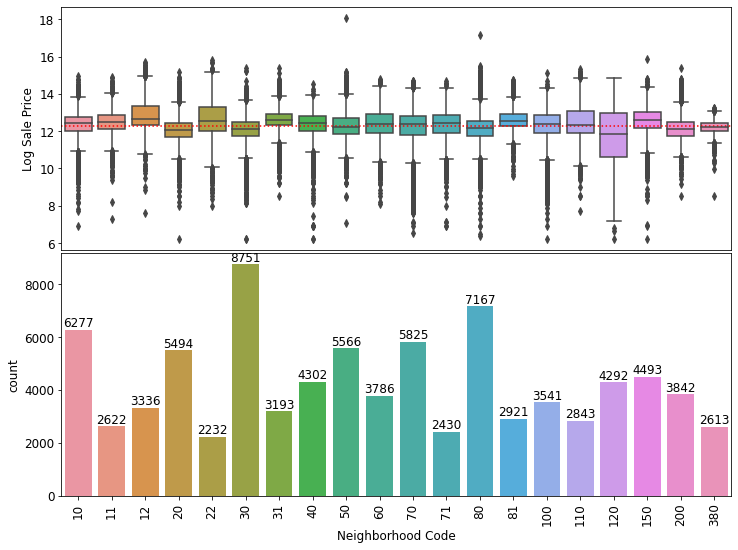

In [540]:
plot_categorical(neighborhoods=in_top_20_neighborhoods, data=training_data)

<!-- END QUESTION -->

### Part 3

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `Log Sale Price` and identify them as "expensive neighborhoods"; the other neighborhoods are not marked.

Write a function that returns list of the neighborhood codes of the top `n` most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_expensive_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `Log Sale Price`.

<!--
BEGIN QUESTION
name: q6c
points: 2
-->

In [541]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code').agg(metric).reset_index().sort_values('Log Sale Price', ascending=False).head(n)['Neighborhood Code']
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

In [542]:
grader.check("q6c")

q6c results: All test cases passed!

### Part 4
We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write a function `add_in_expensive_neighborhood` that adds a column `in_expensive_neighborhood` which takes on the value 1 if the house is part of `expensive_neighborhoods` and the value 0 otherwise. This type of variable is known as an indicator variable.

**Hint:** [`pd.Series.astype`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.astype.html) may be useful for converting True/False values to integers.

<!--
BEGIN QUESTION
name: q6d
points: 1
-->

In [543]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In [544]:
grader.check("q6d")

q6d results: All test cases passed!

## Question 7

In the following question, we will take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

### Part 1

If we look at the codebook carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Central Heating (Nominal): 

       1	Shingle/Asphalt
       2	Tar&Gravel
       3	Slate
       4	Shake
       5    Tile
       6    Other
```

Write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material. Your function should return a new DataFrame, not modify the existing DataFrame.

**Hint**: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.

<!--
BEGIN QUESTION
name: q7a
points: 1
-->


In [545]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    data = data.copy()
    data['Roof Material'] = data['Roof Material'].replace({1: 'Shingle/Asphalt', 2: 'Tar&Gravel', 3:'Slate', 4:'Shake', 5:'Tile', 6:'Other'})
    return data
    
training_data = substitute_roof_material(training_data)

In [546]:
grader.check("q7a")

q7a results: All test cases passed!

### Part 2

#### An Important Note on One Hot Encoding 

Unfortunately, simply fixing these missing values isn't sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data.  Notice in the example code below that we have to pre-specify the categories.  Why? Imagine what would happen if we automatically generated the categories only from the training data.  What would happen if the testing data contained a category not found in the training set?  For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/user_guide/categorical.html).

Complete the following function `ohe_roof_material` that returns a dataframe with the new columns one-hot-encoded on the roof material of the household. These new columns should have the form `x0_MATERIAL`.

**Note**: You should **avoid using `pd.get_dummies`** in your solution as it will remove your original column and is therefore not as reusable as your constructed data preprocessing pipeline. Instead, you can one-hot-encode one column into multiple columns **using Scikit-learn's [One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)**.

<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [547]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit([['Shingle/Asphalt'], ['Tar&Gravel'], ['Slate'], ['Shake'], ['Tile'], ['Other']])
    transformed = enc.transform(data[['Roof Material']]).toarray()
    ohe_df = pd.DataFrame(transformed, columns= enc.get_feature_names())
    return pd.concat([data.reset_index(), ohe_df], axis=1)

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^x0').head(10)

,x0_Other,x0_Shake,x0_Shingle/Asphalt,x0_Slate,x0_Tar&Gravel,x0_Tile
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0


In [548]:
grader.check("q7b")

q7b results: All test cases passed!

## Question 8

Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

"Don't we already have a test set in `cook_county_test.csv`?" you might wonder. The sale prices for `cook_county_test.csv` aren't provided, so we're constructing our own test set for which we know the outputs.

In the cell below, complete the function `train_test_split` that splits `data` into two smaller DataFrames named `train` and `test`. Let `train` contain 80% of the data, and let `test` contain the remaining 20% of the data.

To do this, first create two NumPy arrays named `train_indices` and `test_indices`. `train_indices` should contain a *random* 80% of the indices in `full_data`, and `test_indices` should contain the remaining 20% of the indices. Then, use these arrays to index into `full_data` to create your final `train` and `test` DataFrames.

*The provided tests check that you not only answered correctly, but ended up with the exact same train/test split as our reference implementation. Later testing is easier this way.*

**Note**: You should not be importing any additional libraries for this question.


In [549]:
# This makes the train-test split in this section reproducible across different runs
# of the notebook. You do not need this line to run train_test_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)


# DO NOT CHANGE THIS LINE

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)

    threshold = int(data_len * 0.8)
    train_indicies = shuffled_indices[:threshold]
    test_indicies = shuffled_indices[threshold:]

    train = data.iloc[train_indicies]
    test = data.iloc[test_indicies]
    return train, test


train, test = train_test_split(training_data)


In [550]:
grader.check("q8")

q8 results: All test cases passed!

## Question 9a
Now, let's fit our updated linear regression model using the ordinary least squares estimator! We will start you off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet).

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$


**Without running any calculation or code**, complete the following blanked statement by choosing the correct operator in the below dictionary corresponding to: $$\ge, \le, =$$

Suppose we quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the 1st model and the training loss of the 2nd model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model}  \_\_\_\_\_  \text{Training Loss of the 2nd Model}
$$



In [551]:
idx = 0  # SOLUTION
answer = ('<=', '>=', '==')[idx]

In [552]:
grader.check('q9a')

q9 results: All test cases passed!

# Question 9b:
It is time to prepare the training and validation data for the two models we proposed above. Use the following 3 cells to reload a fresh dataset from scratch and run them through the following preprocessing steps for each model:

- Perform a `train_test_split` on the original dataset. Let 80% of the set be training data and 20% of the set be validation data. **Even though we are splitting our dataset into training and validation sets, this question will refer to the validation set as the test set.**
- For both the training and validation set,
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars).
    2. Apply log transformations to `Sale Price` and the `Building Square Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model).
    5. Return the design matrix $X$ and the observed vector $y$. **Your design matrix and observed vector should either be numpy arrays or pandas dataframes**.


Assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_test_m1`, `y_test_m1`
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_test_m2`, `y_test_m2`

To complete this exercise you will need the previous preprocessing functions.


**Note**: Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset exactly the same way for both models (otherwise their performance isn't directly comparable).


In [553]:
def preprocessing_pipe_m1(data):
    """For sake of reproducability, we create a pipeline, that can be used on this dataset, to be explicit about what we are doing here. There are more elegant ways of specifiying such a pipeline (e.g. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html or
    https://scikit-learn.org/stable/modules/compose.html, but for now we only care for the data to be preprocessed."""
    # BEGIN SOLUTION
    
    data = remove_outliers(data, 'Sale Price', lower=499)
    data = log_transform(data, 'Sale Price')
    data = add_total_bedrooms(data)
    data = data[['Log Sale Price', 'Bedrooms']]

    X = data.loc[:, data.columns != 'Log Sale Price']
    y = data['Log Sale Price']

    # END SOLUTION
    return X, y

In [554]:
full_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, test_m1 = train_test_split(full_data)

X_train_m1, y_train_m1 = preprocessing_pipe_m1(train_m1)
X_test_m1, y_test_m1 = preprocessing_pipe_m1(test_m1)


In [555]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)


# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
def preprocessing_pipe_m2(data):
    # BEGIN SOLUTION
    def log_transform(data, col):
        data['Log ' + col] = np.log(data[col])
        return data
    data = remove_outliers(data, 'Sale Price', lower=499)
    data = log_transform(data, 'Sale Price')
    data = log_transform(data, 'Building Square Feet')
    data = add_total_bedrooms(data)
    data = data[['Log Sale Price', 'Bedrooms', 'Log Building Square Feet']]

    X = data.loc[:, data.columns != 'Log Sale Price']
    y = data['Log Sale Price']
    # END SOLUTION

    return X, y


X_train_m2, y_train_m2 = preprocessing_pipe_m2(train_m1)
X_test_m2, y_test_m2 = preprocessing_pipe_m2(test_m1)


In [570]:
all([np.allclose(X_train_m2.sum(), pd.Series([433901.000000, 984820.624924], index=['Bedrooms', 'Log Building Square Feet']), rtol=1, atol=0), np.allclose(y_train_m2.sum(), 1643505.2095877347)])

True

In [556]:
grader.check("q9b")

q9 results: All test cases passed!

## Question 10

Finally, let's do some regression!

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.

In [557]:
from sklearn.linear_model import LinearRegression

linear_model_m1 = LinearRegression(fit_intercept=True)
linear_model_m2 = LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models, and then use it to compute the fitted values of `Sale Price` over the training data, and the predicted values of `Sale Price` for the testing data.

Assign the predicted values from both of your models on the training and testing set to the following variables:

- 1st Model: prediction on training set: `y_fitted_m1`, prediction on testing set: `y_predicted_m1`
- 2nd Model: prediction on training set: `y_fitted_m2`, prediction on testing set: `y_predicted_m2`

**Note**: To make sure you understand how to find the predicted value for both the training and testing data set, there won't be any hidden tests for this part.
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [558]:
# Fit the 1st model
# Compute the fitted and predicted values of Sale Price for 1st model
linear_model_m1.fit(X_train_m1, y_train_m1)  # SOLUTION
y_fitted_m1 = linear_model_m1.predict(X_train_m1)  # SOLUTION
y_predicted_m1 = linear_model_m1.predict(X_test_m1)  # SOLUTION

In [559]:
# Fit the 2nd model
# Compute the fitted and predicted values of Sale Price for 1st model
linear_model_m2.fit(X_train_m2, y_train_m2)  # SOLUTION
y_fitted_m2 = linear_model_m2.predict(X_train_m2)  # SOLUTION
y_predicted_m2 = linear_model_m2.predict(X_test_m2)  # SOLUTION

In [560]:
grader.check("q10")

q9 results: All test cases passed!

## Question 11

Let's compare the performance of our two regression models using the Root Mean Squared Error function that we created in Homework 6.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

The function is provided below.

In [561]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted) ** 2))

Now use your `rmse` function to calculate the training error and test error for both models in the cell below.

Assign the error from both of your models to the following variables:

- 1st model: `training_error_m1`, `test_error_m1`
- 2nd model: `training_error_m2`, `test_error_m2`

Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.

Assign the error on the "de-log-transformed" sale price from both of your models to the following variables:

- 1st model: `training_error_m1_delog`, `test_error_m1_delog`
- 2nd model: `training_error_m2_delog`, `test_error_m2_delog`

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [562]:
# Training and test errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)  # SOLUTION
test_error_m1 = rmse(y_predicted_m1, y_test_m1)  # SOLUTION

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1), np.exp(y_train_m1))  # SOLUTION
test_error_m1_delog = rmse(np.exp(y_predicted_m1), np.exp(y_test_m1))  # SOLUTION

# Training and test errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)  # SOLUTION
test_error_m2 = rmse(y_predicted_m2, y_test_m2)  # SOLUTION

# Training and test errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.exp(y_fitted_m2), np.exp(y_train_m2))  # SOLUTION
test_error_m2_delog = rmse(np.exp(y_predicted_m2), np.exp(y_test_m2))  # SOLUTION


def pprint_rmse(train_error, test_error, modelname):
    print("{}:\nTraining RMSE: {}\nTest RMSE: {}\n".format(modelname, train_error, test_error))


pprint_rmse(training_error_m1, test_error_m1, '1st Model')
pprint_rmse(training_error_m1_delog, test_error_m1_delog, '1st Model (no log transformation)')
pprint_rmse(training_error_m2, test_error_m2, '2nd Model')
pprint_rmse(training_error_m2_delog, test_error_m2_delog, '2nd Model (no log transformation)')


1st Model:
Training RMSE: 0.9025651719699077
Test RMSE: 0.9068644732045896

1st Model (no log transformation):
Training RMSE: 382697.78149699024
Test RMSE: 310679.2486611569

2nd Model:
Training RMSE: 0.8042009333446841
Test RMSE: 0.8113963052434995

2nd Model (no log transformation):
Training RMSE: 325716.4081916038
Test RMSE: 254880.42228506148



## Question 12

Let's compare the actual parameters ($\theta_0$ and $\theta_1$) from both of our models. As a quick reminder,

for the 1st model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

for the 2nd model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

Run the following cell and compare the values of $\theta_1$ from both models. Why does $\theta_1$ change from positive to negative when we introduce an additional feature in our 2nd model?


In [563]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ0: {}\nθ1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ0: {}\nθ1: {}\nθ2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ0: 10.571725401040084
θ1: 0.4969197463141442
2nd Model
θ0: 1.9339633173823696
θ1: -0.030647249803554506
θ2: 1.4170991378689641


Give an answer by selecting the appropriate answers. Be careful: one or multiple answers might be correct. Specify `idx` as a list of appropriate indices (e.g. `[1,2,3]`).
(1) Because of non-linearities present in the data
(2) Because the two variables are correlated - only if variables are uncorrelated i.e. orthogonal, they will not affect each other's coefficients. (which seldomly is the case)
(3) Because of repeated measurements coefficients can vary. They are following distributions after all.
(4) Because of the train-test split: On different splits different coefficients can occur.
(5) The coefficient follows a distribution with great variance, such that both -0.03 and 0.49 are likely values for the coefficient.

In [565]:
idx = [2]  # SOLUTION

Another way of understanding the performance (and appropriateness) of a model is through a plot of the model predictions versus the observations.

In the cell below, we use `plt.scatter` to plot the predicted `Log Sale Price` from **only the 2nd model** against the original `Log Sale Price` for the test data.


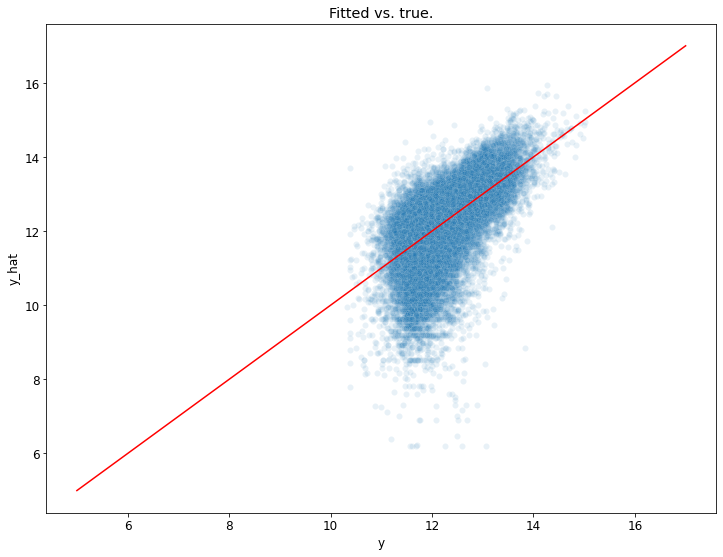

In [566]:
ax = sns.scatterplot(x=linear_model_m2.predict(X_test_m2), y=y_test_m2, alpha=0.1)
ax.set(xlabel="y", ylabel='y_hat', title='Fitted vs. true.')
sns.lineplot(x=range(5, 18), y=range(5, 18), ax=ax, color='red')
plt.show()

As you can see, our simple model has already got off to a good start, but there is certainly still a lot of room for improvement to be made -- one simple reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incorporate more features to improve the model's accuracy? (This is an ungraded and therfore optional exercise and left for you to explore a real world dataset. Should you be able to produce a `delog`ed RMSE on the test set with less than 60k please highlight this fact by sending an email at ruhkopf@stud.uni-hannover.de )

## Congratulations! You have finished Homework 3!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [567]:
grader.check_all()

q9 results: All test cases passed!

q2b results: All test cases passed!

q3a results: All test cases passed!

q3b results: All test cases passed!

q4 results: All test cases passed!

q5a results: All test cases passed!

q5b results: All test cases passed!

q6a results: All test cases passed!

q6b results: All test cases passed!

q6c results: All test cases passed!

q6d results: All test cases passed!

q7a results: All test cases passed!

q7b results: All test cases passed!

q8 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [568]:
# Save your notebook first, then run this cell to export your submission.
grader.export()